# HOMEWORK 1 COMPUTATIONAL PHYSICs

## Importing parameters

In [1]:
import numpy as np
import scipy
import sys
import matplotlib.pyplot as plt

# Parameters
E = 1.5 #meV
epsilon = 5.99 # meV
sigma = 2. # Angstrom
rmax = 500 # Angstrom
h = 0.01
N= rmax/h
r = np.arange(sigma/2, rmax, h)
l = 15


## STEP 1 - Verify the solutions of the SE

In [2]:
h_bar_c = 1.973e6 #mev ångström
m_H = 0.9383e12 #meV / c^2
m_Kr = 83.798 * m_H #meV / c^2
m_r = m_H * m_Kr / (m_H + m_Kr) #meV / c^2
k = np.sqrt(2*m_r*E / h_bar_c**2) #1/ångström WAVE number


prefactor = h_bar_c**2 / (2 * m_r) #meV ångström^2

Now we define the potential to use, in this case Lennard-Jones, and then the Numerov algorithm to solve it

In [3]:
# Potential
def V(r):
    V = 4*epsilon * ((sigma/r)**12 - (sigma/r)**6) #meV
    return V

# Numerov
def Numerov(E,h,l,r):
    y = np.zeros(len(r))
    k = np.zeros(len(r))
    # Initialization of values
    y[0] = 0
    b = 1.25 #wtf is b?
    y[1] = np.exp(-(b/r[1])**5)
    k[0] = 1/prefactor * (E -  V(r[0])) - l * (l + 1) / r[0]**2
    k[1] = 1/prefactor * (E - V(r[1])) - l * (l + 1) / r[1]**2
    
    # Algorithm
    for j in range(2, len(r)):
        k[j] = 1/prefactor *(  E - V(r[j]) )- l * (l + 1) / r[j]**2
        y[j] = (1 / (1 + h**2 / 12 * k[j])) * (y[j-1] * (2 - 5 * h**2 / 6 * k[j-1]) - y[j-2] * (1 + h**2 / 12 * k[j-2]))

    psi = np.zeros(len(r))

    for j in range(len(r)):
        psi[j] = y[j] / r[j]
    return psi


At this point we only need to calculate and normalize the wave function and plot it 

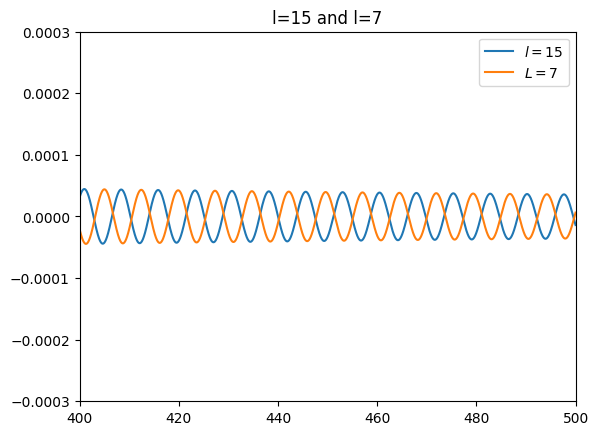

In [4]:
# Normalization
normalizzazione = 0  
normalizzazione7 = 0       
n = np.zeros(len(r))
n7 = n

psi = Numerov(E,h,l,r)
psi7 = Numerov(E,h,5,r)

for j in range(len(r)):
    n[j] = 4 * np.pi * psi[j]**2 * r[j]**2 *h
    normalizzazione += n[j]
    
for j in range(len(r)):
    n7[j] = 4 * np.pi * psi7[j]**2 * r[j]**2 *h
    normalizzazione7 += n7[j]

PSI=psi/np.sqrt(normalizzazione)
PSI7=psi7/np.sqrt(normalizzazione7)


# Visualization
fig, ax = plt.subplots()
ax.set_ylim(-0.0003,0.0003)
ax.set_xlim(400,500)
ax.set_title(r'l=15 and l=7')
ax.plot(r, PSI, label=rf'$l=15$')   
ax.plot(r, PSI7, label=rf'$L=7$')
plt.legend(loc='best')
plt.show()

Conclusions on point 1

## STEP 2 - Compute the phase shifts

In [5]:
# Define Bessel functions

def j_1(r):
    return np.sin(r)/(r**2) - np.cos(r)/r
    
def n_1(r):
    return -np.cos(r)/(r**2) - np.sin(r)/r
    
    
def j_0(r):
    return np.sin(r)/r
    
def n_0(r):
    return -np.cos(r)/r
    
def recursive_bessel(l,sl,sl1,r):
    return ((2*l+1)/(r))*sl - sl1
    
    
def Bessel_l(l,r):
    bess_matj = np.zeros((l,len(r)))
    bess_matn = np.zeros((l,len(r)))
    
    for j in range(len(r)):
        bess_matj[0][j] = j_0(r[j])
        bess_matn[0][j] = n_0(r[j])
        bess_matj[1][j] = j_1(r[j])
        bess_matn[1][j] = n_1(r[j])
        
    for w in range(2,l):
        for j in range(len(r)):
            bess_matj[w][j] = recursive_bessel(w-1,bess_matj[w-1][j], bess_matj[w-2][j],r[j])
            bess_matn[w][j] = recursive_bessel(w-1,bess_matn[w-1][j], bess_matn[w-2][j],r[j])
            
    return bess_matj, bess_matn




            
jj, nn = Bessel_l(l,k*r)       



Now try to use Bessel functions from scipy in order to check if ours are correct

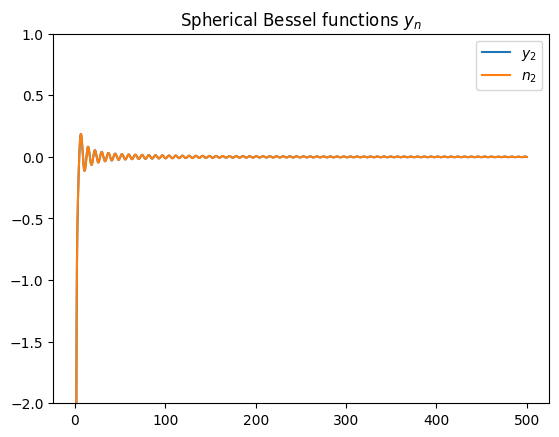

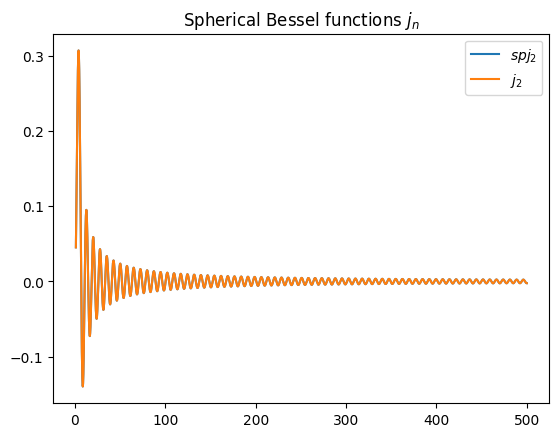

In [6]:
from scipy.special import spherical_jn
from scipy.special import spherical_yn


fig, ax = plt.subplots()
ax.set_ylim(-2.0, 1.0)
ax.set_title(r'Spherical Bessel functions $y_n$')
for n in np.arange(2, 3):
    ax.plot(r, spherical_yn(n, k*r), label=rf'$y_{n}$')   
for n in np.arange(2, 3):
    ax.plot(r, nn[n][:], label=rf'$n_{n}$')
plt.legend(loc='best')
plt.show()



fig, ax = plt.subplots()
ax.set_title(r'Spherical Bessel functions $j_n$')
for n in np.arange(2, 3):
    ax.plot(r, spherical_jn(n, k*r), label=rf'$spj_{n}$')   
for n in np.arange(2, 3):
    ax.plot(r, jj[n][:], label=rf'$j_{n}$')
plt.legend(loc='best')
plt.show()


Since it turns out everything is fine we compute the phase shifts

In [7]:
# Phase shift
def Phase_shift(j_r1,j_r2,n_r1,n_r2,l,kk):
    tan_delta_l=(kk*j_r2[l]-j_r1[l])/(kk*n_r2[l]-n_r1[l])
    delta_l=np.arctan(tan_delta_l)
    return delta_l

r1=len(r)-8100
r2=len(r)-100

kappa=(PSI[r1]*r[r2])/((PSI[r2]*r[r1]))

r1new=len(r)-9400
r2new=len(r)-5600

kappanew=(PSI[r1new]*r[r2new])/((PSI[r2new]*r[r1new]))



jr1 = jj[0:l,r1]
jr2 = jj[0:l,r2]
jr1new = jj[0:l,r1new]
jr2new = jj[0:l,r2new]

nr1 = nn[0:l,r1]
nr2 = nn[0:l,r2]
nr1new = nn[0:l,r1new]
nr2new = nn[0:l,r2new]


shift = Phase_shift(jr1,jr2,nr1,nr2,12,kappa)
shift2 = Phase_shift(jr1new,jr2new,nr1new,nr2new,12,kappanew)
print(shift-shift2) 
print("The phase shift is ", shift) 
print("The phase shift2 is ", shift2) 


0.06364492279013279
The phase shift is  -1.4057060263064458
The phase shift2 is  -1.4693509490965786


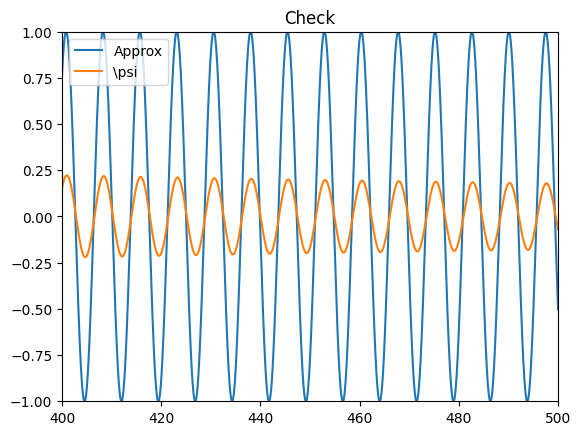

In [8]:
def uck(r,k,d,jj,nn,l):
    u = np.zeros(len(r))
    for i in range(len(r)):
        u[i] = k*r[i]*((np.cos(d)*jj[l-1,i])-(np.sin(d)*nn[l-1,i]))
    
    return u



ucheck = uck(r,k,shift,jj,nn,l)



fig, ax = plt.subplots()
ax.set_xlim(400,500)
ax.set_ylim(-1,1)
ax.set_title(r'Check')
ax.plot(r, ucheck, label=rf'Approx')   
ax.plot(r, 5000*PSI, label=rf'\psi')
plt.legend(loc='best')
plt.show()

## STEP 3 - Commpute the cross section

In [11]:
stepE = 0.001
Evect = np.arange(0.2, 3.5, stepE)

SHIFTS = np.zeros((l,len(Evect)))

lmax = 8

for ii in range(len(Evect)):
    normalizzazione = 0  
    n = np.zeros(len(r))
    psi = Numerov(Evect[ii],h,ll,r)
    for j in range(len(r)):
        n[j] = 4 * np.pi * psi[j]**2 * r[j]**2 *h
        normalizzazione += n[j]
   
    PSI=psi/np.sqrt(normalizzazione)
    
    r1=len(r)-8100
    r2=len(r)-3500
    kappa=(PSI[r1]*r[r2])/((PSI[r2]*r[r1]))
    jr1 = jj[0:lmax,r1]
    jr2 = jj[0:lmax,r2]
    nr1 = nn[0:lmax,r1]
    nr2 = nn[0:lmax,r2]
    for k in range(lmax):
        SHIFTS[k][ii] = Phase_shift(jr1,jr2,nr1,nr2,k,kappa)    


KeyboardInterrupt: 

Now compute the total cross section

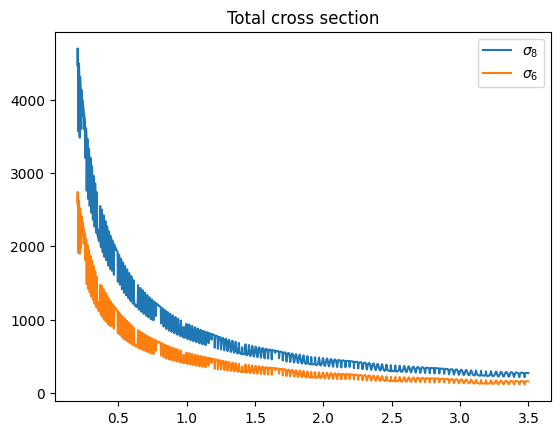

In [97]:
def totalcross(E,n,l):
    factor=(4*np.pi*(h_bar_c**2))/(2*m_r*E)
    sum = 0
    for k in range(l):
        sum+=(2*k+1)*((np.sin(SHIFTS[k][n]))**2)
    
    sig = factor*sum
    return sig

cross = np.zeros(len(Evect))

for i in range(len(Evect)):
    cross[i]=totalcross(Evect[i],i,lmax)
    
    
cross6 = np.zeros(len(Evect))

for i in range(len(Evect)):
    cross6[i]=totalcross(Evect[i],i,6)
    


fig, ax = plt.subplots()
ax.set_title(r'Total cross section')  
ax.plot(Evect, cross, label=rf'$\sigma_8$')
ax.plot(Evect, cross6, label=rf'$\sigma_6$')
plt.legend(loc='best')
plt.show()


